# **Cryptocurrency Price Prediction**

This notebook demonstrates the use of four different time series forecasting models for predicting cryptocurrency prices. The implementation is based on an interactive Jupyter/Colab environment that allows the user to select a cryptocurrency and fiat currency, visualize historical prices, and generate forecasts for the upcoming period.

**Models used:**
1. ARIMA – a classic statistical model suitable for stationary series.
2. Holt-Winters (Exponential Smoothing) – incorporates trend and seasonality to better model patterns.
3. Facebook Prophet – a robust model that automatically detects trends and seasonal effects.
4. LSTM (Long Short-Term Memory) – a deep neural network ideal for capturing nonlinear relationships.

The dataset is downloaded from a public source (Yahoo Finance), covering the period from June 1, 2023 to June 1, 2025.
Forecasts are made for the next 90 days.

**Implementation steps:**
- User input: select cryptocurrency and fiat currency
- Download and display historical data
- Apply linear regression for long-term trend analysis
- Train and predict using 4 models
- Visualize results on a combined plot
- Conclusion on model performance

This notebook illustrates how different models can be applied to the problem of forecasting volatile financial instruments, with potential for further extension via additional evaluation metrics and performance improvements.

**Libraries used:**
- *yfinance* – for downloading historical cryptocurrency data
- *AutoTS, Prophet, statsmodels, tensorflow, sklearn* – for time series modeling
- *matplotlib* – for visualization
- *ipywidgets* – for interactive input
"""


In [1]:
# Install required libraries
!pip install -q yfinance autots matplotlib ipywidgets statsmodels prophet tensorflow


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from autots import AutoTS
from datetime import timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import ipywidgets as widgets
from IPython.display import display, clear_output


In [3]:
# Define currency options
crypto_options = {
    "Bitcoin (BTC)": "BTC",
    "Ethereum (ETH)": "ETH",
    "Dogecoin (DOGE)": "DOGE",
    "Litecoin (LTC)": "LTC",
    "Cardano (ADA)": "ADA",
    "Ripple (XRP)": "XRP",
}

fiat_options = ["USD", "EUR", "GBP", "JPY", "RUB"]
forecast_length = 90
start_date = '2023-06-01'
end_date = '2025-06-01'

"""**Select cryptocurrency and fiat currency**
User selects:

- One cryptocurrency (e.g., BTC)
- One fiat currency (e.g., USD)

This enables dynamic downloading of data for a specific pair, e.g., BTC-USD.
"""

In [4]:
# Dropdown to select cryptocurrency
crypto_select = widgets.Dropdown(
    options=crypto_options.keys(),
    description='Cryptocurrency:',
    value='Bitcoin (BTC)',
    style={'description_width': 'initial'}
)


In [5]:
# Dropdown to select fiat currency
fiat_select = widgets.Dropdown(
    options=fiat_options,
    description='Fiat Currency:',
    value='USD'
)

In [6]:
# Button to run the analysis
run_button = widgets.Button(description="📊 Run Analysis", button_style='success')

"""**Downloading historical data (June 1, 2023 – June 1, 2025)**
We use the "Close" column (closing price) as the target variable (y) for prediction.
"""


'**Downloading historical data (June 1, 2023 – June 1, 2025)**\nWe use the "Close" column (closing price) as the target variable (y) for prediction.\n'

In [7]:
# Function triggered when the button is clicked
# Executes everything: fetches data, trains models, displays results

def on_button_click(b):
    clear_output(wait=True)
    display(crypto_select, fiat_select, run_button)

    selected_crypto = crypto_options[crypto_select.value]
    selected_fiat = fiat_select.value
    ticker = f"{selected_crypto}-{selected_fiat}"

    # Download data from Yahoo Finance
    df_raw = yf.download(ticker, start=start_date, end=end_date)
    if df_raw.empty or 'Close' not in df_raw.columns:
        print("⚠️ No data available.")
        return

    df = df_raw[['Close']].reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'])

    # Plot historical prices
    plt.figure(figsize=(12, 4))
    plt.plot(df['ds'], df['y'], label='Historical Prices')
    plt.title(f"{ticker} - Historical Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid()
    plt.legend()
    plt.show()

    # Linear regression on historical trend
    df['Date_ordinal'] = df['ds'].map(pd.Timestamp.toordinal)
    X = df[['Date_ordinal']]
    y_reg = df['y']
    linear_model = LinearRegression().fit(X, y_reg)
    y_pred = linear_model.predict(X)

    plt.figure(figsize=(14, 4))
    plt.plot(df['ds'], df['y'], label='History', color='blue')
    plt.plot(df['ds'], y_pred, label='Linear Regression', color='red', linestyle='--')
    plt.title(f"{ticker} - Trend + Linear Regression")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Prepare training data
    df_train = df.copy()
    df_train = df_train[df_train['y'].notnull()]

    last_date = df_train['ds'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_length)

    results = {}

    # ARIMA model (AutoTS)
    arima_model = AutoTS(forecast_length=forecast_length, frequency='D', model_list=['ARIMA'], ensemble=None)
    arima_model = arima_model.fit(df_train, date_col='ds', value_col='y', id_col=None)
    arima_forecast = arima_model.predict().forecast
    arima_forecast.index = future_dates
    results['ARIMA'] = arima_forecast['y'].values

    # Holt-Winters model
    hw_model = ExponentialSmoothing(df_train['y'], trend='add', seasonal=None).fit()
    hw_forecast = hw_model.forecast(forecast_length)
    results['Holt-Winters'] = hw_forecast.values

    # Prophet model
    prophet_model = Prophet()
    prophet_model.fit(df_train)
    future_df = pd.DataFrame({'ds': future_dates})
    prophet_forecast = prophet_model.predict(future_df)
    results['Prophet'] = prophet_forecast['yhat'].values

    # LSTM model – normalization
    lstm_df = df_train.set_index('ds').copy()
    scaler_min = lstm_df['y'].min()
    scaler_max = lstm_df['y'].max()
    lstm_df['y'] = (lstm_df['y'] - scaler_min) / (scaler_max - scaler_min)

    window_size = 30
    X, y_lstm = [], []
    for i in range(window_size, len(lstm_df)):
        X.append(lstm_df['y'].values[i-window_size:i])
        y_lstm.append(lstm_df['y'].values[i])
    X, y_lstm = np.array(X), np.array(y_lstm)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    lstm_model = Sequential([
        LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X, y_lstm, epochs=10, verbose=0)

    # Recursive prediction
    last_sequence = lstm_df['y'].values[-window_size:]
    predictions = []
    for _ in range(forecast_length):
        input_seq = np.reshape(last_sequence, (1, window_size, 1))
        pred = lstm_model.predict(input_seq, verbose=0)[0][0]
        predictions.append(pred)
        last_sequence = np.append(last_sequence[1:], pred)

    # Denormalization
    lstm_predictions = np.array(predictions) * (scaler_max - scaler_min) + scaler_min
    results['LSTM'] = lstm_predictions

    # Visualization of all forecasts + history
    plt.figure(figsize=(14, 6))
    plt.plot(df['ds'], df['y'], label='History', color='black')
    for model_name, forecast in results.items():
        plt.plot(future_dates, forecast, label=model_name)
    plt.title(f"Model Comparison - {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid()
    plt.legend()
    plt.show()

    # Forecasts only (no history)
    pred_df = pd.DataFrame(results, index=future_dates)
    pred_df.plot(figsize=(12, 4), title="Forecast Comparison")
    plt.xlabel("Date")
    plt.ylabel("Predicted Price")
    plt.grid()
    plt.show()

Dropdown(description='Cryptocurrency:', options=('Bitcoin (BTC)', 'Ethereum (ETH)', 'Dogecoin (DOGE)', 'Liteco…

Dropdown(description='Fiat Currency:', options=('USD', 'EUR', 'GBP', 'JPY', 'RUB'), value='USD')

Button(button_style='success', description='📊 Run Analysis', style=ButtonStyle())

/tmp/ipython-input-7-1511915767.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


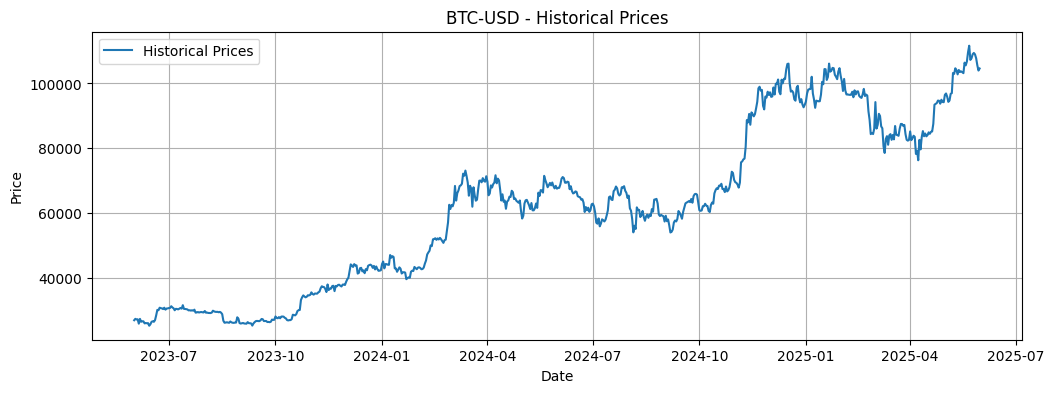

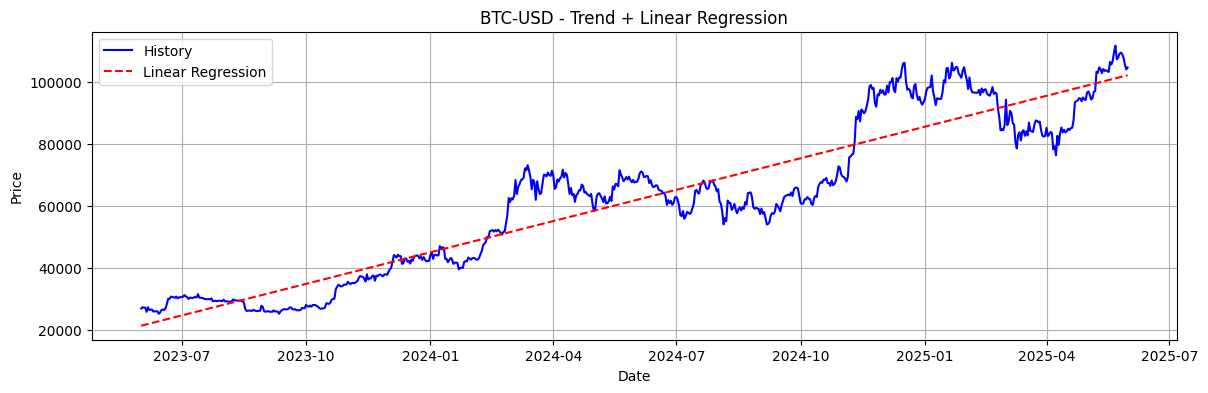

Using 1 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 25
Model Number: 2 with model ARIMA in generation 0 of 25
Model Number: 3 with model ARIMA in generation 0 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 3 in generation 0: ARIMA
Model Number: 4 with model ARIMA in generation 0 of 25
Model Number: 5 with model ARIMA in generation 0 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 5 in generation 0: ARIMA
Model Number: 6 with model ARIMA in generation 0 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 6 in generation 0: ARIMA
New Generation: 1 of 25
Model Number: 7 with model ARIMA in generation 1 of 25
Model Number: 8 with model ARIMA in generation 1 of 25
Model Number: 9 with model ARIMA in generation 1 of 25
Model Number: 10 with model ARIMA i

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:592: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")


Model Number: 41 with model ARIMA in generation 7 of 25
New Generation: 8 of 25
Model Number: 42 with model ARIMA in generation 8 of 25
Model Number: 43 with model ARIMA in generation 8 of 25
Model Number: 44 with model ARIMA in generation 8 of 25
Model Number: 45 with model ARIMA in generation 8 of 25
Model Number: 46 with model ARIMA in generation 8 of 25
New Generation: 9 of 25
Model Number: 47 with model ARIMA in generation 9 of 25
Model Number: 48 with model ARIMA in generation 9 of 25
Model Number: 49 with model ARIMA in generation 9 of 25
Model Number: 50 with model ARIMA in generation 9 of 25
Model Number: 51 with model ARIMA in generation 9 of 25
New Generation: 10 of 25
Model Number: 52 with model ARIMA in generation 10 of 25
Model Number: 53 with model ARIMA in generation 10 of 25
Model Number: 54 with model ARIMA in generation 10 of 25
Model Number: 55 with model ARIMA in generation 10 of 25
Model Number: 56 with model ARIMA in generation 10 of 25
New Generation: 11 of 25
M

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.66369e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


New Generation: 12 of 25
Model Number: 62 with model ARIMA in generation 12 of 25
Model Number: 63 with model ARIMA in generation 12 of 25
Model Number: 64 with model ARIMA in generation 12 of 25
Model Number: 65 with model ARIMA in generation 12 of 25
Model Number: 66 with model ARIMA in generation 12 of 25
New Generation: 13 of 25
Model Number: 67 with model ARIMA in generation 13 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 67 in generation 13: ARIMA
Model Number: 68 with model ARIMA in generation 13 of 25
Model Number: 69 with model ARIMA in generation 13 of 25
Template Eval Error: ValueError('operands could not be broadcast together with shapes (360,1) (90,1) ') in model 69 in generation 13: ARIMA
Model Number: 70 with model ARIMA in generation 13 of 25
Model Number: 71 with model ARIMA in generation 13 of 25
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 71 in gener

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 80 with model ARIMA in generation 15 of 25
Template Eval Error: Exception('Transformer DatepartRegression failed on fit from params nearest {\'0\': {\'constraint_method\': \'round\', \'constraint_direction\': \'upper\', \'constraint_regularization\': 1.0, \'constraint_value\': 2, \'bounds_only\': False, \'fillna\': None}, \'1\': {\'center\': \'midhinge\'}, \'2\': {\'constant\': 0, \'reintroduction_model\': {\'model\': \'KNN\', \'model_params\': {\'n_neighbors\': 14, \'weights\': \'uniform\', \'p\': 2, \'leaf_size\': 30}, \'datepart_method\': \'simple\'}, \'fillna\': \'mean\'}, \'3\': {\'regression_model\': {\'model\': \'MLP\', \'model_params\': {\'hidden_layer_sizes\': [72, 36, 72], \'max_iter\': 1000, \'activation\': \'relu\', \'solver\': \'adam\', \'early_stopping\': True, \'learning_rate_init\': 0.001, \'alpha\': None}}, \'datepart_method\': [\'weekdayofmonth\', \'common_fourier\'], \'polynomial_degree\': None, \'transform_dict\': None, \'holiday_countries_used\': Fals

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


New Generation: 16 of 25
Model Number: 82 with model ARIMA in generation 16 of 25
Model Number: 83 with model ARIMA in generation 16 of 25
Model Number: 84 with model ARIMA in generation 16 of 25
Model Number: 85 with model ARIMA in generation 16 of 25
Model Number: 86 with model ARIMA in generation 16 of 25
New Generation: 17 of 25
Model Number: 87 with model ARIMA in generation 17 of 25
Model Number: 88 with model ARIMA in generation 17 of 25
Model Number: 89 with model ARIMA in generation 17 of 25
Model Number: 90 with model ARIMA in generation 17 of 25
Model Number: 91 with model ARIMA in generation 17 of 25
New Generation: 18 of 25
Model Number: 92 with model ARIMA in generation 18 of 25
Model Number: 93 with model ARIMA in generation 18 of 25


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 94 with model ARIMA in generation 18 of 25
Model Number: 95 with model ARIMA in generation 18 of 25
Model Number: 96 with model ARIMA in generation 18 of 25
New Generation: 19 of 25
Model Number: 97 with model ARIMA in generation 19 of 25
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params ffill_mean_biased {'0': {'lag_1': 96, 'method': 5}, '1': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 0.2, 'first_value_only': False, 'threshold': 3, 'threshold_method': 'mean'}, '2': {'lag': 2, 'fill': 'bfill'}, '3': {'method': None, 'method_params': None, 'transform_dict': None, 'reverse_alignment': True, 'isolated_only': False, 'fillna': 3.0}, '4': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.03, 'min_child_weight': 10, 'subsample': 1, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1}, 'datepart_method': ['dayofweek', 365.25]}, 'fillna': 'linear'}} with e

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.66369e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 118 with model ARIMA in generation 23 of 25
Model Number: 119 with model ARIMA in generation 23 of 25
Model Number: 120 with model ARIMA in generation 23 of 25
Model Number: 121 with model ARIMA in generation 23 of 25
New Generation: 24 of 25
Model Number: 122 with model ARIMA in generation 24 of 25
Model Number: 123 with model ARIMA in generation 24 of 25
Model Number: 124 with model ARIMA in generation 24 of 25
Template Eval Error: Exception("Transformer BTCD failed on fit from params zero {'0': {}, '1': {'regression_model': {'model': 'LinearRegression', 'model_params': {}}, 'max_lags': 2}, '2': {}, '3': {'n_harmonics': 10, 'detrend': 'quadratic'}} with error ValueError('BTCD only works on multivarate series')") in model 124 in generation 24: ARIMA
Model Number: 125 with model ARIMA in generation 24 of 25
Model Number: 126 with model ARIMA in generation 24 of 25
Template Eval Error: Exception("Transformer AnomalyRemoval failed on fit from params rolling_mean_24 {'0': {'

/usr/local/lib/python3.11/dist-packages/autots/evaluator/auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
/usr/local/lib/python3.11/dist-packages/autots/evaluator/auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. C

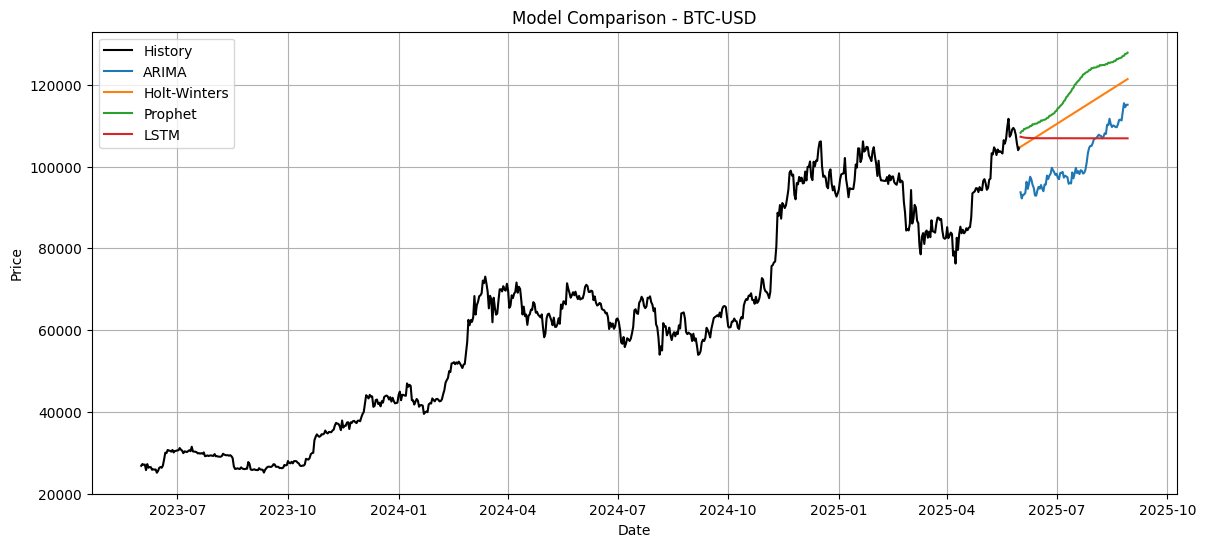

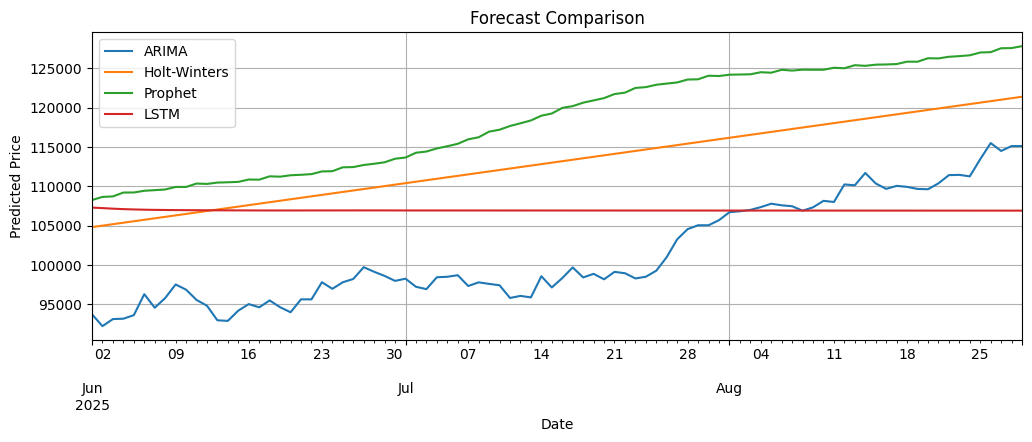

In [8]:
# Launch interactive widgets
run_button.on_click(on_button_click)
display(crypto_select, fiat_select, run_button)


"""**Conclusion**

This project demonstrates how various time series and deep learning models can be used to predict cryptocurrency prices. Each model has unique strengths:

- *ARIMA* – suitable for short-term stable patterns.
- *Holt-Winters* – strong for data with trend components.
- *Prophet* – ideal for automatic detection of trend and seasonality.
- *LSTM* – powerful for capturing complex, nonlinear relationships.
"""